# $floZ$: Bayesian evidence estimation from posterior samples with normalizing flows
## Run this notebook if you wish to reproduce the $floZ$ paper results.

### Note our convention: we use the natural logarithm (base e), instead of the common log (base 10).
### If you have used this code for your research, please cite https://arxiv.org/abs/2404.12294

In [1]:
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import corner
plt.rcParams.update({'font.size': 20})
plt.rc('font',**{'family':'serif'})
plt.rc('text', usetex=True)
import pandas as pd

# Import floZ training and pre-processing functions
from floZ_LossCycle import Trainer
from floZ_LossCycle.train import _pre_whitening

# Import functions to generate and sample from likelihood, and calculate evidence.
from floZ_LossCycle.utils_SampleGeneration import *
from floZ_LossCycle.utils_Zestimation import symmetrize

# Setting seed, if needed reproducability. Default = None for random seeds.
MCMC_seed = None
# MCMC_seed = 1
np.random.seed(MCMC_seed)

## Initialize likelihood label, sample dimension and number of samples.

In [2]:
# Un-comment the required likelihood label

## Single Gaussian
N = 1; likelihood_label = 'Likelihood-'+str(N)+'Gaussian'; ndims = 2; ninput = 10000

## Gaussian Mixture
# N = 5; likelihood_label = 'Likelihood-'+str(N)+'Gaussian'; ndims = 2; ninput = 10000

## Rosenbrock
# likelihood_label = 'Likelihood-Rosenbrock'; ndims = 2; ninput = 10000

## Exponential
# likelihood_label = 'Likelihood-Exponential'; ndims = 2; ninput = 10000

## Generating reference samples - distribution parameters saved for reproducability

In [3]:
if likelihood_label != 'custom':
    floZpath_ref = f'./'+likelihood_label+'_{}d_ninput[10000]'.format(ndims)
    
    get_new_distribution = True
    if os.path.exists(floZpath_ref):
        get_new_distribution = False
    else:
        os.makedirs(floZpath_ref)

    print(floZpath_ref)

    if get_new_distribution:
        if(likelihood_label == 'Likelihood-Rosenbrock'):
            init_Rosenbrock(ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref)
        elif(likelihood_label == 'Likelihood-Exponential'):
            if ndims ==2:
                init_Exponential(ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref, lambdas = [0.009057, 0.005257])
            else:
                init_Exponential(ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref)
        elif(len(likelihood_label.split('Gaussian'))>1):
            if(ndims ==2 and N==1):
                init_NGaussian(N, ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref,
                          means = [[23, 35]], covs = [[[299, 31],[31, 284]]])
            elif(ndims ==2 and N==5):
                init_NGaussian(N, ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref,
                              means = [[39, 19], [30, 38], [18, 12], [46, 44], [28, 28]], 
                               covs = [[[29, 8], [8,118]], [[250,15],[15,171]], [[152,4],[4, 32]], [[173, 12],[12, 107]], [[198, 17],[17, 468]]])  
            else:
                init_NGaussian(N, ndims = ndims, ninput=10000, floZpath_ref=floZpath_ref)
                

./Likelihood-1Gaussian_2d_ninput[10000]
Mean  1
[23, 35]
Covariance Matrix  1
[[299, 31], [31, 284]]
Shapes of means (1, 2), and covariances (1, 2, 2)


lnPRIOR =  [-9.82652066 -9.82652066 -9.82652066 ... -9.82652066 -9.82652066
 -9.82652066]
ln Evidence  -9.826553052179312


Likelihood =  [1.37438541e-04 1.86588551e-04 2.71807722e-04 ... 1.88211741e-05
 2.35217815e-04 6.16923777e-05]
ln Z =  -9.826553052179312
Limits  [array([-38.80465543, -33.10972861]), array([ 96.20158917, 104.05733573])]


## Loading pre-existing samples, if any

In [4]:
floZpath = f'./'+likelihood_label+'_{}d_ninput[{}]'.format(ndims, ninput)
print(floZpath)

pre_existing = os.path.exists(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt'))      

if pre_existing:
    lnZ_GT = np.loadtxt(os.path.join(floZpath, 'lnZ_GT.txt'))
    s = np.loadtxt(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt'))
    log_likelihood = s[:,0]
    log_prior = s[:,1]
    log_p = log_likelihood + log_prior
    samples = s[:,2:]

    log_prior = log_prior[log_p!=-np.inf]
    samples = samples[log_p!=-np.inf]
    log_likelihood = log_likelihood[log_p!=-np.inf]
    log_p = log_p[log_p!=-np.inf]
    meanmean = np.mean(samples, axis = 0)

    if ndims < 10:
        # Plot the corner plot
        figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True, truths=meanmean)
        figure.suptitle("Current Samples", y=1.02, fontsize=16)
        plt.show()
    
    
    plt.figure()
    plt.title('log_p histogram')
    print(np.min(log_p), np.max(log_p))
    bins = np.linspace(np.min(log_p), np.max(log_p), 100)
    plt.hist(log_p[log_p != -np.inf], bins = bins, histtype = 'step', label = 'Final samples: {}'.format(len(log_p)))
    plt.yscale('log')
    plt.xlabel('log_p')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

./Likelihood-1Gaussian_2d_ninput[10000]


## If it doesnt already exist, generate samples from the reference, recalculating log(likelihood x prior).



Importing samples, means, covs from  ./Likelihood-1Gaussian_2d_ninput[10000]
Imported ln Z =  -9.826553052179312
Shape of imported means (1, 2) and covs (1, 2, 2)
Imported Limits [[-38.80465543 -33.10972861]
 [ 96.20158917 104.05733573]]
Oversampled sample size  (50000, 2)
Boxed sample size  (49984, 2)
Downsampled sample size (10000, 2)


lnPRIOR =  [-9.82652066 -9.82652066 -9.82652066 ... -9.82652066 -9.82652066
 -9.82652066]
ln Evidence  -9.826553052179312


Likelihood =  [4.44517010e-04 8.85173264e-05 1.90787631e-04 ... 5.03955079e-04
 4.54460212e-04 3.40145698e-04]
Recalculated ln Z =  -9.826553052179312


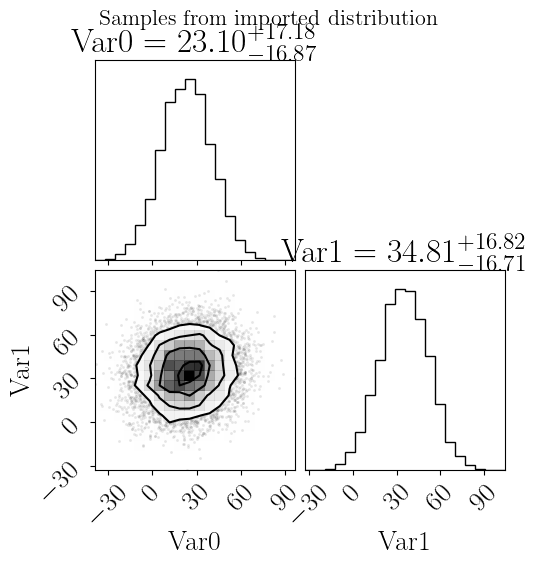

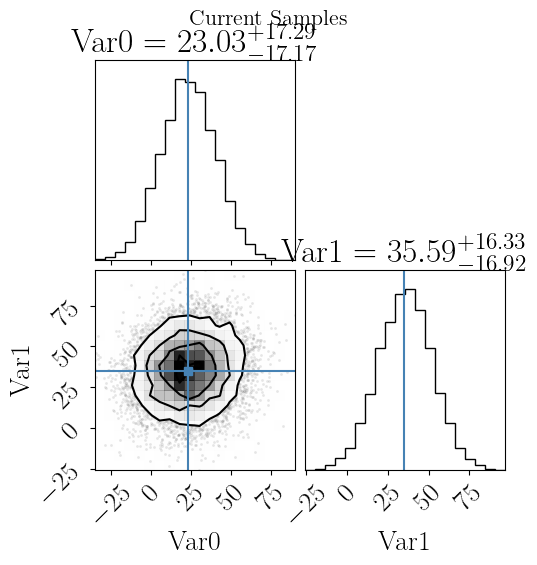

-26.12503399917459 -17.333460370863442


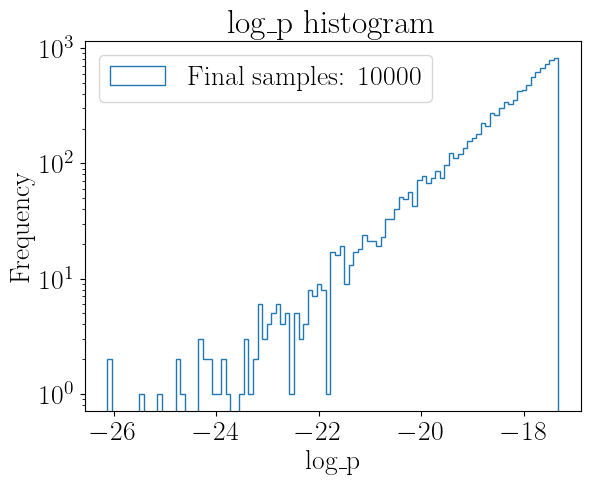

In [5]:
if not pre_existing:
    ###################### Rosenbrock ###########################
    
    if(likelihood_label == 'Likelihood-Rosenbrock'):
        print('\n\nImporting samples from ', floZpath_ref)
        s = np.loadtxt(os.path.join(floZpath_ref, 'samples_logp.txt'))
        samples_ref = s[:, :-1]
        log_p = s[:, -1]
        Z = np.loadtxt(os.path.join(floZpath_ref, 'Z.txt'))
        limits = np.loadtxt(os.path.join(floZpath_ref, 'limits.txt'))
        min_theta = limits[0,:]
        max_theta = limits[1,:]
        print('Imported ln Z = ', np.log(Z))
        
        if ndims <= 16:
            figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
            figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)
        
        # Generate MCMC samples with loaded prior bounds
        initial_state = np.zeros(ndims)
        samples = metropolis_hastings(6*ninput, initial_state)
        print('Oversampled sample size ', samples.shape)
    
        # Discard samples outside prior limits.
        for dim in range(ndims):
            samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
        samples=samples[~np.isnan(samples[:,0]), :]
        samples = np.array(samples)
        print('Boxed sample size ', samples.shape)
    
        # Downsampling to ninputs samples.
        samples=samples[random.sample(range(len(samples)), ninput),:]
        samples = np.array(samples)
        print('Downsampled sample size', samples.shape)
    
        log_p, Z = calc_Rosenbrock_log_p_Z(samples, min_theta, max_theta, ndims)
        print('Recalculated log Z ', np.log(Z))
        lnZ_GT = np.log(Z)
        
        save_Rosenbrock(floZpath, samples, log_p, limits, Z)
        meanmean = np.mean(samples, axis = 0)
    
    ###################### Exponential ###########################
    
    elif(likelihood_label == 'Likelihood-Exponential'):
        print('\n\nImporting samples and lambda from ', floZpath_ref)
        s = np.loadtxt(os.path.join(floZpath_ref, 'samples_logp.txt'))
        samples_ref = s[:, :-1]
        log_p = s[:,-1]
        Z = np.loadtxt(os.path.join(floZpath_ref, 'Z.txt'))
        limits = np.loadtxt(os.path.join(floZpath_ref, 'limits.txt'))
        lambdas = np.loadtxt(os.path.join(floZpath_ref, 'lambdas.txt'))
    
        print('\nLambdas: \n', lambdas)
        min_theta = limits[0,:]
        max_theta = limits[1,:]
        print('Imported ln Z = ', np.log(Z))
        
        if ndims <= 16:
            figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
            figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)
        
        # Generate MCMC samples with loaded likelihood and prior bounds
        samples = generate_n_dimensional_exponential(N=ndims, lambdas=lambdas, size=5*ninput)
        print('Oversampled sample size ', samples.shape)
        
        # Discard samples outside prior limits.
        for dim in range(ndims):
            samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
        samples=samples[~np.isnan(samples[:,0]), :]
        samples = np.array(samples)
        print('Boxed sample size ', samples.shape)
    
        # Downsampling to ninputs samples.
        if(len(samples)>ninput):
            samples=samples[:ninput,:]
            samples = np.array(samples)
        print('Downsampled sample size', samples.shape)
    
        log_p, Z = calc_Exponential_log_p_Z(samples, min_theta, max_theta, lambdas)
        print('Recalculated log Z ', np.log(Z))
        lnZ_GT = np.log(Z)
    
        save_Exponential(floZpath, samples, log_p, limits, Z, lambdas)
        
        meanmean = np.mean(samples, axis = 0)

    ####################### NGaussian ###########################
    
    elif(len(likelihood_label.split('Gaussian'))>1):
        print('\n\nImporting samples, means, covs from ', floZpath_ref)
        s = np.loadtxt(os.path.join(floZpath_ref, 'samples_logp.txt'))
        samples_ref = s[:, :-1]
        lnZ_GT = np.loadtxt(os.path.join(floZpath_ref, 'ln_Z.txt'))
        print('Imported ln Z = ', lnZ_GT)
        means = np.load(os.path.join(floZpath_ref, 'means.npy'))
        covs = np.load(os.path.join(floZpath_ref, 'covs.npy'))
        print('Shape of imported means {} and covs {}'.format(means.shape, covs.shape))
        limits = np.loadtxt(os.path.join(floZpath_ref, 'limits.txt'))
        print('Imported Limits', limits)
        min_theta = limits[0,:]
        max_theta = limits[1,:]
    
        figure = corner.corner(np.transpose(samples_ref.T), labels=["Var"+str(index) for index in range(len(samples_ref.T))], show_titles=True)
        figure.suptitle("Samples from imported distribution", y=1.02, fontsize=16)
    
        samples = []
        vars = []
        meanmean = np.zeros(ndims)
        # Sample from loaded likelihood.
        for idx in range(N):
            meanmean += means[idx]
            samples += list(np.random.multivariate_normal(means[idx], covs[idx], 5*ninput//N))
            vars += [multivariate_normal(mean=means[idx], cov=covs[idx])]
        meanmean /= N
        samples = np.array(samples)
        print('Oversampled sample size ', samples.shape)
    
        # Discard samples outside prior limits.
        for dim in range(ndims):
            samples[np.where((samples[:,dim]>max_theta[dim]) | (samples[:,dim]<min_theta[dim])),:]*=np.nan
        samples=samples[~np.isnan(samples[:,0]), :]
        samples = np.array(samples)
        print('Boxed sample size ', samples.shape)
    
        # Downsampling to ninputs samples.
        samples=samples[random.sample(range(len(samples)), ninput),:]
        samples = np.array(samples)
        print('Downsampled sample size', samples.shape)
    
        log_p, lnZ_GT = calc_NGaussian_log_p_lnZ(N, samples, min_theta, max_theta, vars)
        print('Recalculated ln Z = ', lnZ_GT)
        
        save_NGaussian(floZpath, samples, log_p, limits, lnZ_GT, means, covs)
        
    
    if ndims < 10:
        # Plot the corner plot
        figure = corner.corner(np.transpose(samples.T), labels=["Var"+str(index) for index in range(len(samples.T))], show_titles=True, truths = meanmean)
        figure.suptitle("Current Samples", y=1.02, fontsize=16)
        plt.show()
    
    #sc = plt.scatter(samples.T[0],samples.T[1], c=log_p, cmap='viridis', s=10, alpha=0.7)
    #cbar = plt.colorbar(sc, label='log (likelihood x prior)')
    
    plt.figure()
    plt.title('log_p histogram')
    print(np.min(log_p[log_p!=-np.inf]), np.max(log_p))
    bins = np.linspace(np.min(log_p[log_p!=-np.inf]), np.max(log_p), 100)
    plt.hist(log_p, bins = bins, histtype = 'step', label = 'Final samples: {}'.format(len(log_p)))
    plt.yscale('log')
    plt.xlabel('log_p')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

else:
    print('Distribution samples already exist!')


## If not pre-existing, save Z, log_prior, log_likelihood, samples

In [6]:
if not pre_existing:
    # Log likelihood for kNN calculation
    if(len(likelihood_label.split('pyring'))==1):
        prior = get_priors(samples, min_theta, max_theta)
        if prior[0] != 0.:
            log_prior = np.log(prior)
        else:
            log_prior = get_log_priors(samples, min_theta, max_theta)
        log_prior = log_prior
        log_likelihood = log_p-log_prior
    [log_p!=-np.inf]
    np.savetxt(os.path.join(floZpath, 'loglikelihood_logprior_samples.txt'), np.hstack((log_likelihood[:, np.newaxis], log_prior[:, np.newaxis], samples)))
    np.savetxt(os.path.join(floZpath, 'lnZ_GT.txt'), [lnZ_GT])